In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
import tensorflow_hub as hub

In [9]:
df = pd.read_csv('wine-reviews.csv', usecols=['country', 'description', 'points', 'price', 'variety', 'winery'])
df = df.dropna(subset=['description', 'points'])
df.head()

,country,description,points,price,variety,winery
0,Italy,"Aromas include tropical fruit, broom, brimston...",87,NaN,White Blend,Nicosia
1,Portugal,"This is ripe and fruity, a wine that is smooth...",87,15.0,Portuguese Red,Quinta dos Avidagos
2,US,"Tart and snappy, the flavors of lime flesh and...",87,14.0,Pinot Gris,Rainstorm
3,US,"Pineapple rind, lemon pith and orange blossom ...",87,13.0,Riesling,St. Julian
4,US,"Much like the regular bottling from 2012, this...",87,65.0,Pinot Noir,Sweet Cheeks


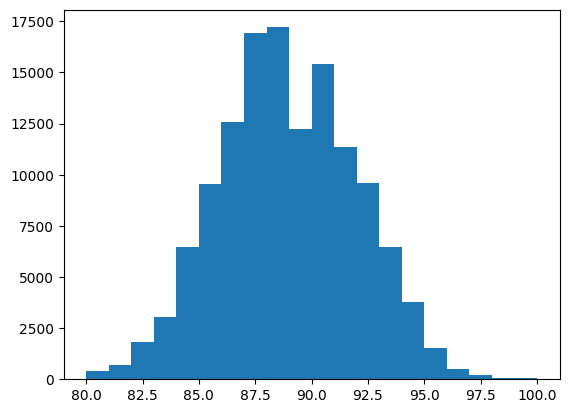

In [10]:
plt.hist(df.points, bins=20)
plt.show()

In [11]:
df['label'] = (df.points >= 90).astype(int)
df = df[['description','label']]
df.head()

,description,points,label
0,"Aromas include tropical fruit, broom, brimston...",87,0
1,"This is ripe and fruity, a wine that is smooth...",87,0
2,"Tart and snappy, the flavors of lime flesh and...",87,0
3,"Pineapple rind, lemon pith and orange blossom ...",87,0
4,"Much like the regular bottling from 2012, this...",87,0


In [12]:
train, val, test = np.split(df.sample(frac=1), [int(0.8 * len(df)), int(0.9 * len(df))])

In [13]:
# df to dataset
def df_to_dataset(df, shuffle=True, batch_size=1024):
    df = df.copy()
    labels = df.pop('label')
    df = df['description']
    ds = tf.data.Dataset.from_tensor_slices((df, labels))
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(batch_size)
    ds = ds.prefetch(tf.data.AUTOTUNE)
    return ds

In [14]:
train_data = df_to_dataset(train)
val_data = df_to_dataset(val)
test_data = df_to_dataset(test)

In [15]:
embedding = 'https://tfhub.dev/google/nnlm-en-dim50/2'
hub_layer = hub.KerasLayer(embedding, dtype=tf.string, trainable=True)

In [16]:
hub_layer(list(train_data)[0][0])

<tf.Tensor: shape=(1024, 50), dtype=float32, numpy=
array([[ 0.49137688, -0.04103763,  0.2289691 , ..., -0.13959178,
        -0.1096576 , -0.07856172],
       [ 0.1730817 , -0.28096035,  0.09439368, ..., -0.3049483 ,
        -0.227349  ,  0.1721902 ],
       [ 0.3519924 , -0.29346374,  0.08300483, ...,  0.07821645,
        -0.15949194, -0.05450796],
       ...,
       [ 0.48564684, -0.23631565, -0.05616054, ...,  0.13483314,
        -0.14207897, -0.11570604],
       [ 0.32397735,  0.13062961,  0.05182326, ...,  0.06834196,
        -0.44402987,  0.17222066],
       [ 0.34613782, -0.23701133,  0.06228303, ..., -0.10175777,
        -0.06378816,  0.05116463]], dtype=float32)>

In [17]:
model = tf.keras.Sequential()
model.add(hub_layer)
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(16, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [18]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001), loss=tf.keras.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [20]:
history = model.fit(train_data, validation_data=val_data, epochs=20)

Epoch 1/20


102/102 [==============================] - 74s 699ms/step - loss: 0.5959 - accuracy: 0.6700 - val_loss: 0.4426 - val_accuracy: 0.7948
Epoch 2/20
102/102 [==============================] - 57s 558ms/step - loss: 0.3833 - accuracy: 0.8245 - val_loss: 0.3795 - val_accuracy: 0.8253
Epoch 3/20
102/102 [==============================] - 57s 556ms/step - loss: 0.3334 - accuracy: 0.8511 - val_loss: 0.3714 - val_accuracy: 0.8300
Epoch 4/20
102/102 [==============================] - 56s 551ms/step - loss: 0.3078 - accuracy: 0.8657 - val_loss: 0.3738 - val_accuracy: 0.8293
Epoch 5/20
102/102 [==============================] - 57s 555ms/step - loss: 0.2892 - accuracy: 0.8754 - val_loss: 0.3783 - val_accuracy: 0.8293
Epoch 6/20
102/102 [==============================] - 56s 552ms/step - loss: 0.2728 - accuracy: 0.8836 - val_loss: 0.3900 - val_accuracy: 0.8299
Epoch 7/20
102/102 [==============================] - 57s 562ms/step - loss: 0.2593 - accuracy: 0.8904 - val_loss: 0.3933 - val_accuracy: 0.8

In [22]:
model.evaluate(test_data)

13/13 [==============================] - 1s 68ms/step - loss: 0.6418 - accuracy: 0.8277


[0.641771674156189, 0.8277427554130554]

LSTM

In [23]:
encoder = tf.keras.layers.TextVectorization(max_tokens=2000)
encoder.adapt(train_data.map(lambda text, label: text))

In [ ]:
vocab = np.array(encoder.get_vocabulary())

In [24]:
model = tf.keras.Sequential([
    encoder,
    tf.keras.layers.Embedding(
        input_dim=len(encoder.get_vocabulary()),
        output_dim=32,
        mask_zero=True
    ),
    tf.keras.layers.LSTM(32),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dropout(0.4),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

In [26]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [27]:
history = model.fit(train_data, validation_data=val_data, epochs=5)

Epoch 1/5
102/102 [==============================] - 56s 451ms/step - loss: 0.5573 - accuracy: 0.7023 - val_loss: 0.3863 - val_accuracy: 0.8213
Epoch 2/5
102/102 [==============================] - 45s 440ms/step - loss: 0.3693 - accuracy: 0.8348 - val_loss: 0.3570 - val_accuracy: 0.8372
Epoch 3/5
102/102 [==============================] - 39s 376ms/step - loss: 0.3494 - accuracy: 0.8450 - val_loss: 0.3571 - val_accuracy: 0.8372
Epoch 4/5
102/102 [==============================] - 33s 323ms/step - loss: 0.3415 - accuracy: 0.8476 - val_loss: 0.3524 - val_accuracy: 0.8385
Epoch 5/5
102/102 [==============================] - 33s 321ms/step - loss: 0.3367 - accuracy: 0.8515 - val_loss: 0.3534 - val_accuracy: 0.8373


In [28]:
model.evaluate(test_data)

13/13 [==============================] - 2s 146ms/step - loss: 0.3410 - accuracy: 0.8441


[0.34102728962898254, 0.8440529108047485]